In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as dset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
# %run model_add_res.ipynb
# %run model_2.ipynb
%run unet.ipynb
# from model.ipynb import *

torch.Size([16, 1, 32, 32])


In [2]:
batch = 16
N = 120
epoch = 100
DOWNLOAD = True
device_str = "cuda" if torch.cuda.is_available() else "cpu"
# device_str = "cpu"
resize = 32
save_name = "sm_2"
device = torch.device(device_str)
print(device)

cuda


In [3]:
epsilon = 0.002
T = 80
ro = 7
time_schedule = lambda i: (epsilon**(1/ro) + (i)/(N-1)*(T**(1/ro) - epsilon**(1/ro)))**ro 
# time_schedule = lambda i: torch.linspace(epsilon, T, N+1)[i]
# dt = time_schedule(2) - time_schedule(1)

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,) ,(0.5,)),
]
)

trainset = torchvision.datasets.MNIST(
    root = 'dataset/mnist',
    train = True,
    transform = data_transform, #改成torch可讀
    download = DOWNLOAD,
)


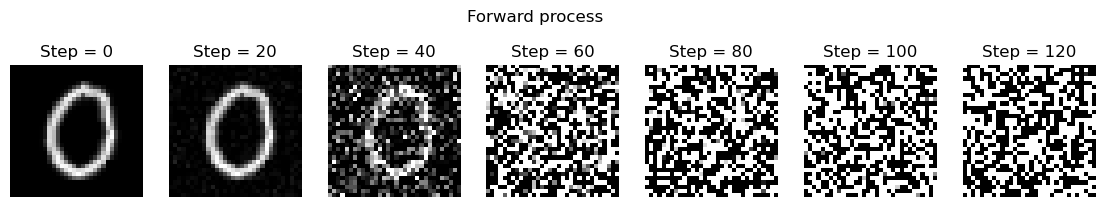

In [5]:
trainLoader = dset.DataLoader(trainset, batch_size=batch, shuffle=True)
x_test = next(iter(trainLoader))[0]
x_test_set = []
x_test_set.append(x_test)

for i in range(N):
    time = time_schedule(torch.ones(len(x_test)).long() * (i-1))
    noise = torch.randn_like(x_test)
    x_test_set.append(x_test + time[:, None, None, None] * noise)


# x_temp = x.to(device="cpu", dtype=torch.float32).numpy().transpose((0, 2, 3, 1))  # [0][999]
#     x_temp = np.clip(x_temp, 0.0, 1.0)
steps = int(20)
num_steps = int(N/steps)+1


fig = plt.figure(figsize=(2 * num_steps, 2.5))
# fig.set_figwidth(2 * num_steps)
fig.suptitle("Forward process")
for j in range(num_steps):
    plt.subplot(1, num_steps, j+1)     #将窗口分为两行两列四个子图，则可显示四幅图片
    plt.title('Step = {}'.format(j*steps))   #第一幅图片标题    #绘制第一幅图片
    plt.imshow(np.clip(x_test_set[j*steps][0].numpy().transpose((1, 2, 0)), 0.0, 1.0), cmap = "gray")      #绘制第一幅图片
    plt.axis("off")

# fig.tight_layout()
# plt.subplots_adjust(wspace = 0, hspace = 0)


In [ ]:
trainLoader = dset.DataLoader(trainset, batch_size=batch, shuffle=True)
lr = 1e-3
f_theta = Unet().to(device)
optimizer = torch.optim.Adam(f_theta.parameters(), lr=lr)
loss_func = nn.MSELoss()
loss_set = []
batch_loss = []


### Load model
# f_theta = Unet().to(device)
# checkpoint = torch.load(f"weights/eps_theta_{save_name}.pt", weights_only=False)
# # checkpoint = torch.load(f"weights/eps_theta_score_2.pt", weights_only=False)
# f_theta.load_state_dict(checkpoint['model_state_dict'])
# loss_set = checkpoint['loss_set']
# optimizer = torch.optim.Adam(f_theta.parameters(), lr=lr)
# loss_func = nn.MSELoss()


# accumulation_steps = 50
pbar = tqdm(range(epoch))
for ep in pbar:
    # for ep in range(epoch):
    for X_data, _ in trainLoader:
        # with torch.autocast(device_type=device_str, dtype=torch.bfloat16):

        X_data = X_data.to(device)
        index = torch.randint(N, size=(X_data.shape[0],))
        time = time_schedule(index)
        time_previous = time_schedule(index-1)
        delta_t = time - time_previous
        # forward of DDPM
        noise = torch.randn_like(X_data)
        # Xt = X_data + (2 * time_schedule(index) * delta_t).sqrt()[:, None, None, None].to(device) * noise
        Xt = X_data + time_schedule(index)[:, None, None, None].to(device) * noise
        c_skip = lambda t: 0.25 / ((t - epsilon) ** 2 + 0.25)
        c_out = lambda t: 0.5 * (t - epsilon) / (t ** 2 + 0.25).sqrt()
        D_theta = c_skip(time)[:, None, None, None].to(device) * X_data \
        + c_out(time)[:, None, None, None].to(device) * f_theta(Xt, time.to(device))  # 餵給net吃訓練數據x, 輸出預測值
        # f_2 = f_theta_mius(Xt, time_schedule(time).to(device))  # 餵給net吃訓練數據x, 輸出預測值
        loss = loss_func(D_theta, X_data)
        # # 訓練網路三個最主要步驟

        # loss = loss / accumulation_steps
        
        optimizer.zero_grad()  # 梯度清0
        loss.backward()  # 誤差反向傳導
        optimizer.step()  # 神經網路參數更新
        
        # if (i+1) % accumulation_steps == 0:
        #     optimizer.step()  # 神經網路參數更新
        #     optimizer.zero_grad()  # 梯度清0
        # update_theta_mius(f_theta, f_theta_mius, mu)
        pbar.set_description('Loss: {}'.format(loss.item()))  # 更新pbar
        # print('Loss{}: {}'.format(loss.item()))
        # lr = 8e-5 if loss<0.02 else 1e-3
        loss_set.append(loss.item())

iteration = np.arange(len(loss_set))
fig = plt.figure()
plt.loglog(iteration, loss_set, "-")
# plt.show()

In [7]:
try:
    checkpoint
except NameError:
    epoch_last = 0
else:
    epoch_last = checkpoint["epoch"]
torch.save({
    # 'statement':
    # f"This model is U-net structure and DDPM process with linear schedule. \n
    #   It trained for {epoch_last + epoch} epoches with {N} steps. \n  
    #   The dictionary save the model, trained parameter of model, Adam optimizer and loss. \n
    #   You can keep training for your goal with the dictionary."
    'epoch': epoch,
    'step': N,
    'model': f_theta,
    'model_state_dict': f_theta.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_set': loss_set
}, f"weights/eps_theta_{save_name}.pt")
iteration = np.arange(len(loss_set))
fig = plt.figure()
plt.loglog(iteration, loss_set, "-")
plt.savefig(f"{save_name}.png")
plt.close()

In [6]:
torch.set_float32_matmul_precision('high')
Total_data = 60000
# batch = 64#1000
dtype = torch.float32
Total_iter = Total_data // batch + (Total_data % batch != 0)
device_str = "cuda" if torch.cuda.is_available() else "cpu"
# model_weight_name = "cifar10_5"
device = torch.device(device_str)

In [7]:
### Loading model
# save_name = "score_u_2"
save_name = "sm_2"
f_theta = Unet().to(device)
checkpoint = torch.load(f"weights/eps_theta_{save_name}.pt", weights_only=False)
f_theta.load_state_dict(checkpoint['model_state_dict'])
f_theta = f_theta.eval()
X_data, _ = next(iter(trainLoader))
results =[]

![EDM_Algorithm_2](./EDM_Algorithm_2.png)

In [10]:
X_data, _ = next(iter(trainLoader))
X_data = X_data.to(device)
s_noise = 1.1
x = torch.randn(batch, 1, 32, 32,device=device, dtype=dtype) * epsilon
x_motion = x.unsqueeze(-1)

gamma = np.sqrt(2)

# f = lambda x, t :x*10

for i in tqdm(range(N, 0, -1)):
    with torch.inference_mode(), torch.amp.autocast(enabled=True, device_type=device_str, dtype=torch.bfloat16):
        noise = torch.randn(batch, 1, 32, 32,device=device, dtype=dtype) * s_noise
        time = time_schedule(torch.ones(len(x),device=device, dtype=dtype) * (i))
        time_hat = (1 + gamma) * time
        x_hat = x + torch.sqrt(time_hat**2 - time**2)[:, None, None, None] * noise
        
        c_skip = lambda t: 0.25 / ((t - epsilon)**2 + 0.25)
        c_out = lambda t: 0.5 * (t - epsilon) / (t**2 + 0.25).sqrt()
        D_theta = c_skip(time_hat)[:, None, None, None].to(device) * X_data \
            + c_out(time_hat)[:, None, None, None].to(device) * f_theta(x_hat, time_hat.to(device))
            # + c_out(time_hat)[:, None, None, None].to(device) * f(x_hat, time_hat.to(device))
        
        d = (x_hat - D_theta) / time_hat[:, None, None, None] 
        x = x_hat + (time_schedule(i+1) - time_hat)[:, None, None, None]  * d
        if i != 0:
            d_prime = (x_hat - D_theta) / time_schedule(i+1)
            x = x_hat + (time_schedule(i+1) - time_hat)[:, None, None, None]  * (d + d_prime)/2
    x_motion = torch.hstack([x_motion, x.unsqueeze(-1)])
        
# result.append(x)   # Save the result
x = transforms.Resize((28, 28))(x)
x_temp = x.to(device="cpu", dtype=torch.float32).numpy().transpose((0, 2, 3, 1))  # [0][999]
x_temp = np.clip(x_temp, 0.0, 1.0)
# results.append((x_temp * 255).astype(np.uint8))


100%|██████████| 120/120 [00:00<00:00, 243.25it/s]


In [9]:
pbar = tqdm(range(1))
# pbar = tqdm(range(Total_iter))
for k in pbar:
    stard_id = k * batch
    end_id = min((k + 1) * batch, Total_data)
    num_of_data = end_id - stard_id
    # backward process
    with torch.inference_mode(), torch.amp.autocast(enabled=True, device_type=device_str, dtype=torch.bfloat16):
        #with torch.amp.autocast():
        # x = torch.randn(num_of_data, 1, 32, 32,device=device, dtype=dtype) * np.sqrt(80)
        x = torch.randn(num_of_data, 1, 32, 32,device=device, dtype=dtype) * T
        # x = x_test_set[-1].type_as(x)
        x_motion = x.unsqueeze(-1)
        
        for i in range(N, 60, -1):
            time = time_schedule(torch.ones(len(x),device=device, dtype=dtype) * (i))
            # time = time_schedule(torch.ones(len(x)).long() * (i))
            time_previous = time_schedule(torch.ones(len(x),device=device, dtype=dtype) * (i-1))
            # time_previous = time_schedule(torch.ones(len(x)).long() * (i-1))
            delta_t = time - time_previous
            # delta_t = dt
            prediction = f_theta(x, time.to(device))

            exact_score = lambda x, t: -(x - X_data) / t[:, None, None, None]**2
            
            # x = x - time[:, None, None, None] * prediction.squeeze(-1)\
            # x = x - 2 * time[:, None, None, None] * prediction.squeeze(-1) / time_previous[:, None, None, None]\
                # + (2 * time[:, None, None, None]).sqrt() * torch.randn_like(x, device=device, dtype=dtype)
            
            # x = x - 2 * time[:, None, None, None] *prediction.squeeze(-1) * delta_t[:, None, None, None] / time_previous[:, None, None, None]\
            x = x -  time[:, None, None, None] *prediction.squeeze(-1) * delta_t[:, None, None, None]\
                # + (2*time[:, None, None, None] * delta_t[:, None, None, None]).sqrt() * torch.randn_like(x, device=device, dtype=dtype)
                # +(time[:, None, None, None] * delta_t[:, None, None, None]*.sqrt() * torch.randn_like(x, device=device, dtype=dtype)

            ### Exact score sampling
            # x = x + 2 * time[:, None, None, None] * exact_score(x, time) * delta_t[:, None, None, None]\
                # + (2 * time[:, None, None, None] * delta_t[:, None, None, None]).sqrt() * torch.randn_like(x, device=device, dtype=dtype)
            
            x_motion = torch.hstack([x_motion, x.unsqueeze(-1)])
            pbar.set_description(f"current batch reverse process: {(N - i)} / {N} ")
        
        # time = time_schedule(torch.ones(len(x), dtype=torch.long) * (1)).to(device)
        time = time_schedule(torch.ones(len(x),device=device, dtype=dtype) * (1))
        # time_previous = time_schedule(torch.ones(len(x),dtype=torch.long) * (0))
        time_previous = time_schedule(torch.ones(len(x),device=device, dtype=dtype) * (0))
        delta_t = time - time_previous
        prediction = f_theta(x, time)
        x = x - 2 * time[:, None, None, None] * prediction.squeeze(-1)
        
        # x = x + 2 * time[:, None, None, None] * exact_score(x, time) * delta_t[:, None, None, None]
        # torch.cuda.empty_cache()
    x_motion = torch.hstack([x_motion, x.unsqueeze(-1)])

    # result.append(x)   # Save the result
    x = transforms.Resize((28, 28))(x)
    x_temp = x.to(device="cpu", dtype=torch.float32).numpy().transpose((0, 2, 3, 1))  # [0][999]
    x_temp = np.clip(x_temp, 0.0, 1.0)
    # results.append((x_temp * 255).astype(np.uint8))

    
#results = np.concatenate(results, axis=0)
#print(results.dtype, results.shape)
#np.save(f"result_2/{model_weight_name}_result.npy", results) # (batch, 32, 32, 3), dtype = uint8 range(0, 255)

    # # x_motion = resize(x_motion.squeeze(-1))
    # save per image
    # for j in range(num_of_data):
    #     plt.figure(figsize=(32, 32), dpi=1)
    #     plt.imshow(x_temp[j])

    #     plt.axis("off")
    #     plt.margins(0, 0)
    #     plt.gca().xaxis.set_major_locator(plt.NullLocator())
    #     plt.gca().yaxis.set_major_locator(plt.NullLocator())

    #     plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    #     plt.savefig(f"result_2/fig{k*batch+j}",dpi = 1, pad_inches = 0)   #显示窗口
    #     plt.clf()
    #     plt.close()


    # result = torch.cat(result, dim=0)
    # torch.save(result, f"result/x.pth")
    # print(result.shape)
    #         asd/2

current batch reverse process: 59 / 120 : 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


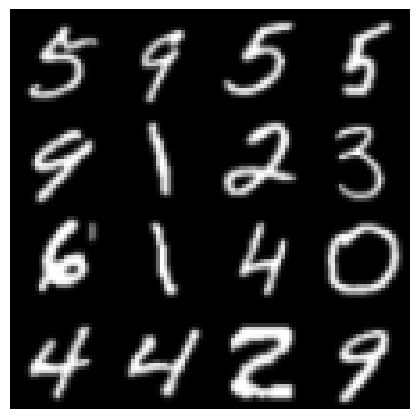

In [11]:
num_fig = 4
steps = int(N/5)
num_steps = int(N/steps)+1
# N=1000

fig = plt.figure(figsize=(num_fig, num_fig))
# fig.suptitle("Ruslt (x64)")
for j in range(num_fig**2):
    plt.subplot(num_fig, num_fig, j+1)     #将窗口分为两行两列四个子图，则可显示四幅图片
    # plt.title('Step = {}'.format(N - i))   #第一幅图片标题
    # plt.imshow(x_motion[j][-1], cmap = "gray")      #绘制第一幅图片
    plt.imshow(x_temp[j], cmap = "gray")      #绘制第一幅图片
    plt.axis("off")
    # plt.pause(1).

fig.tight_layout()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

# plt.show()   #显示窗口
# plt.savefig("SM_sample_8")   #显示窗口
# plt.savefig("DDPM_2hr")   #显示窗口

In [13]:
# Plot reverse process

# x = transforms.Resize((28, 28))(x)
x_motion_cpu = x_motion.to(device="cpu", dtype=torch.float32).numpy().transpose((0, 1, 2, 3, 4))  # [0][999]
x_motion_cpu = np.clip(x_motion_cpu, 0.0, 1.0)

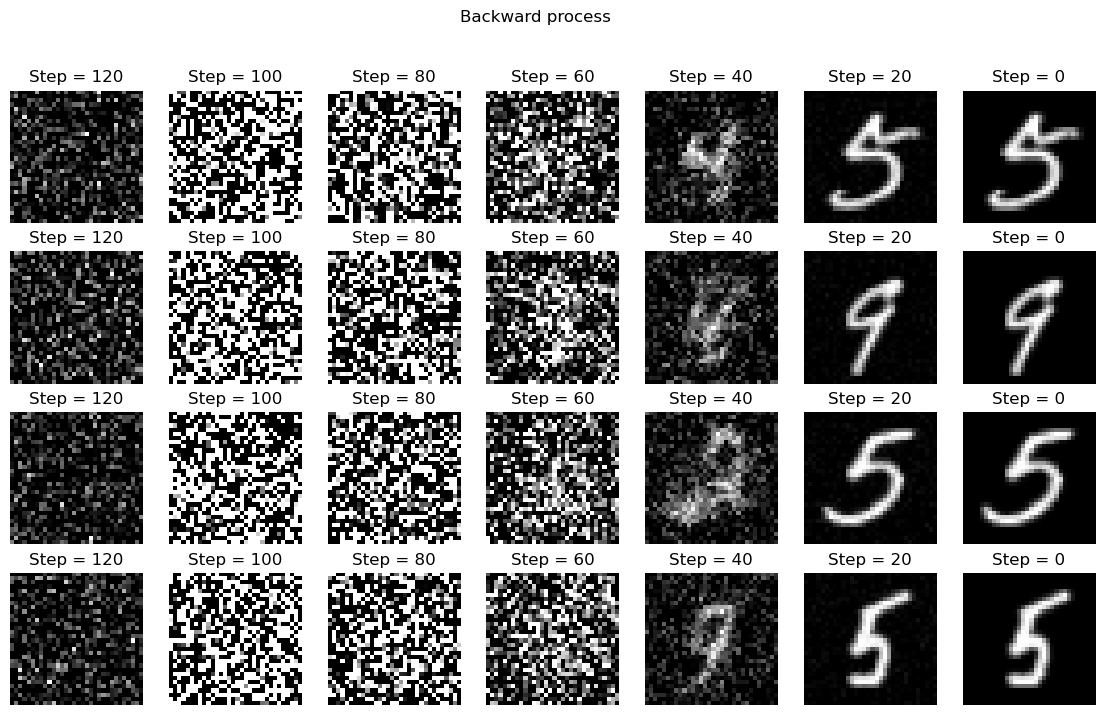

In [14]:
num_fig = 4
steps = 20
num_steps = int(N/steps)+1

fig = plt.figure(figsize=(2*num_steps , 2*num_fig))
fig.suptitle("Backward process")

for j in range(num_fig):
    for i in range(0, N+1, steps):
        plt.subplot(num_fig, num_steps, int(i/steps) + num_steps*j+1)     #将窗口分为两行两列四个子图，则可显示四幅图片
        plt.title('Step = {}'.format(N - i))   #第一幅图片标题
        plt.imshow(x_motion_cpu[j][i], cmap = "gray")      #绘制第一幅图片
        plt.axis("off")
        # plt.pause(1)

# plt.show()   #显示窗口
# plt.savefig("SM_sample_8")   #显示窗口